<a href="https://colab.research.google.com/github/krishnamanojaayakadu/python-random-quote/blob/master/FBProphet_forecasting_Tata_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

supply chain and preventive maintenince

### Model FBPROPHET Time Series Forecasting

In [ ]:
!pip install prophet

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_x=pd.read_csv('/content/gdrive/MyDrive/TATAMOTORS.NS.csv')
train_x.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-05-06,289.445404,306.710236,289.445404,305.770294,302.287781,25177117
1,2013-05-13,302.406403,308.639526,292.265167,300.130798,296.712494,31395018
2,2013-05-20,302.356934,312.844421,279.848358,285.042633,281.796173,40125142
3,2013-05-27,283.558563,316.109406,282.123932,309.975220,306.444794,45509331
4,2013-06-03,306.462891,314.427460,294.837585,298.696198,295.294250,33151519


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import kpss



# Extract the time series data into a NumPy array
ts = train_x['ds'].values

# Perform the KPSS test
kpss_test = kpss(ts)

# Extract the test statistic and p-value
test_statistic = kpss_test[0]
p_value = kpss_test[1]

# Print the results
print('KPSS test statistic: ', test_statistic)
print('p-value: ', p_value)


KPSS test statistic:  3.3714641767458855
p-value:  0.01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# # assuming we have a DataFrame called "df" with a DateTimeIndex

# # specify the number of splits (i.e., number of test sets)
# n_splits = 2

# # create the TimeSeriesSplit object
# tscv = TimeSeriesSplit(n_splits=n_splits)

# # loop over each split and split the data into training and testing sets
# for train_index, test_index in tscv.split(TataMotors):
#     train_x = TataMotors.iloc[train_index]
#     test_x = TataMotors.iloc[test_index]
    
#     # do something with the training and testing data


In [ ]:
print(train_x['Date'].max())
print(train_x['Date'].min())

train_x['Date']=pd.to_datetime(train_x['Date'])
train_x=train_x.drop(columns="Volume")

2023-05-05
2013-05-06


<Figure size 3000x3000 with 0 Axes>

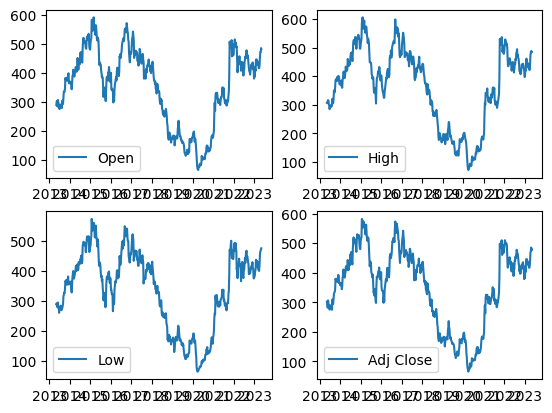

In [ ]:
plt.figure(figsize=(30, 30))

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].plot(train_x['Date'], train_x['Open'], label='Open')
axes[0, 1].plot(train_x['Date'], train_x['High'], label='High')
axes[1, 0].plot(train_x['Date'], train_x['Low'], label='Low')
axes[1, 1].plot(train_x['Date'], train_x['Adj Close'], label='Adj Close')
axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()

plt.show()

In [ ]:
train_x.rename(columns={'Date':'ds','Open' :'y'},inplace=True)

In [ ]:
model=Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=0.1)
model.add_regressor('High')
model.add_regressor('Low')
model.add_regressor('Close')
model.add_regressor('Adj Close')
model.fit(train_x)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsyz_kt_9/d2an50hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsyz_kt_9/08c4p5dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20565', 'data', 'file=/tmp/tmpsyz_kt_9/d2an50hu.json', 'init=/tmp/tmpsyz_kt_9/08c4p5dx.json', 'output', 'file=/tmp/tmpsyz_kt_9/prophet_model79xfdr2f/prophet_model-20230507152909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
regression_data=train_x[['ds','High','Low','Close','Adj Close']]
# List of regressors     
regressors = ['High','Low','Close','Adj Close']
future_df = model.make_future_dataframe(periods=365, freq='D').tail(365)
future_df

,ds
523,2023-05-06
524,2023-05-07
525,2023-05-08
526,2023-05-09
527,2023-05-10
...,...
883,2024-04-30
884,2024-05-01
885,2024-05-02
886,2024-05-03


prophet model

In [ ]:
future_w_regressors = regression_data[regressors+['ds']].merge(future_df, how='outer', on='ds')
future_w_regressors
# Get the segment for which we have no regressor values
empty_future = future_w_regressors[future_w_regressors[regressors[0]].isnull()]
only_future = empty_future[['ds']]
# Create a dictionary to hold the different independent variable forecasts 
for regressor in regressors: 
    # Prep a new training dataset
    train = regression_data[['ds',regressor]]
    train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

    # Train a model for this regressor 
    rmodel = Prophet(seasonality_mode='multiplicative')
    rmodel.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=0.1)
    rmodel.fit(train)
    regressor_predictions = rmodel.predict(only_future)

    # Replace the empty values in the empty dataset with the predicted values from the regressor model 
    empty_future[regressor] = regressor_predictions['yhat'].values
    
# Fill in the values for all regressors in the future_w_regressors dataset 
future_w_regressors.loc[future_w_regressors[regressors[0]].isnull(), regressors] = empty_future[regressors].values


In [ ]:
test_x = pd.merge(future_df, future_w_regressors, on='ds', how='inner')
test_x

,ds,High,Low,Close,Adj Close
0,2023-05-06,474.419823,456.435060,463.629880,463.953216
1,2023-05-07,474.597058,456.027550,463.724523,464.028620
2,2023-05-08,474.920245,455.727628,463.931387,464.217225
3,2023-05-09,475.379297,455.537294,464.242989,464.511753
4,2023-05-10,475.961331,455.456583,464.650108,464.903170
...,...,...,...,...,...
360,2024-04-30,533.117962,524.793042,524.010136,524.973143
361,2024-05-01,532.402185,523.785341,523.389818,524.328800
362,2024-05-02,531.847048,522.852129,522.899816,523.814584
363,2024-05-03,531.461633,522.007007,522.545130,523.435771


In [ ]:
forecast = model.predict(future_w_regressors)

In [ ]:
Final_forecast=forecast[['ds','yhat']]

In [ ]:
Final_forecast

,ds,yhat
0,2013-05-06,294.157440
1,2013-05-13,300.854739
2,2013-05-20,304.008617
3,2013-05-27,291.439876
4,2013-06-03,308.758152
...,...,...
883,2024-04-30,179.194653
884,2024-05-01,176.870455
885,2024-05-02,174.463505
886,2024-05-03,253.894248


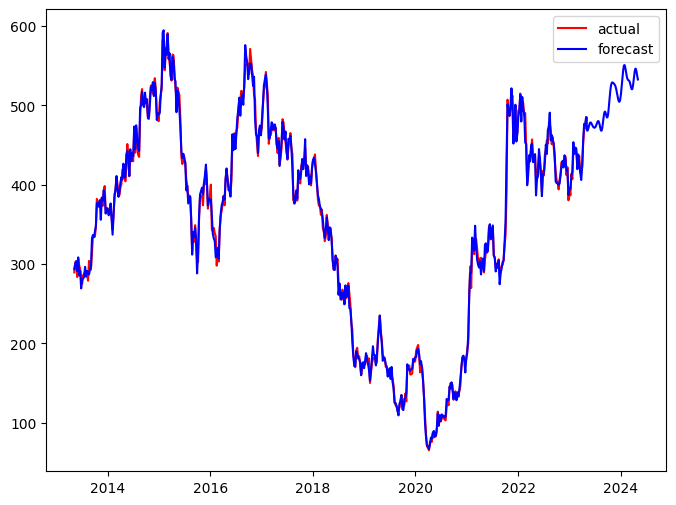

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_x['ds'],train_x['y'],color='red',label='actual')
plt.plot(Final_forecast['ds'],Final_forecast['yhat'],color='blue',label='forecast')
plt.legend()